In [200]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

## Load dataset

In [201]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
# -- add: index_col=0
df = pd.read_excel(r"C:\Users\user\Desktop\機器學習助教\python_check\Default.xlsx", index_col=0)

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


### Figure 4.1

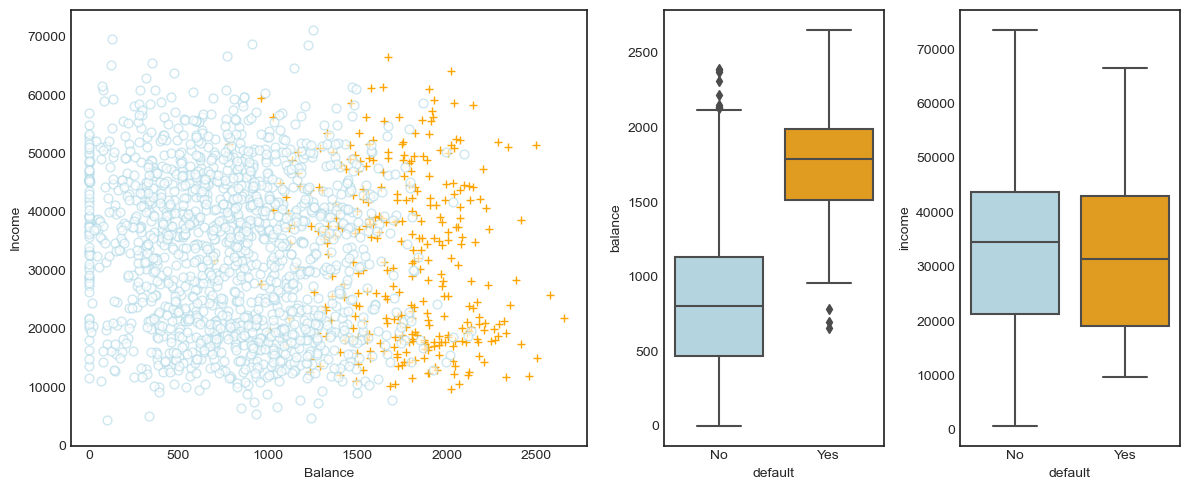

In [202]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
# -- change "df_no.append(df_yes)" to "change pd.concat([df_yes, df_no])"
df_ = pd.concat([df_yes, df_no])

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
# -- change linewidths='1' to change linewidths=1
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths=1,
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
# -- change sns.boxplot('default', 'balance', data=df) to boxplot(data=df, x='default', y='balance')
sns.boxplot(data=df, x='default', y='balance', orient='v', ax=ax2, palette=c_palette)
sns.boxplot(data=df, x='default', y='income', orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

### Figure 4.2

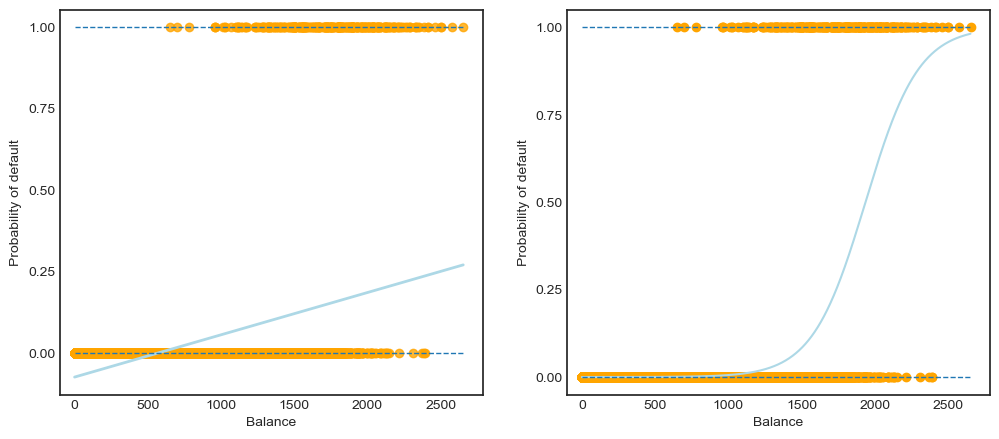

In [203]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

# -- change LogisticRegression(solver='newton-cg') to LogisticRegression(solver='lbfgs')
clf = skl_lm.LogisticRegression(solver='lbfgs')
clf.fit(X_train,y)

prob = clf.predict_proba(X_test)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(data=df, x=df.balance, y=df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)


### Table 4.1

In [204]:
y = df.default2

#### scikit-learn

In [205]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
# -- change LogisticRegression(solver='newton-cg') to LogisticRegression(solver='lbfgs')
clf = skl_lm.LogisticRegression(solver='lbfgs')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression()
classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65132824]


#### statsmodels

In [206]:
'''
delete
X_train = sm.add_constant(df.balance)
'''
# --change 'smf.Logit(y.ravel(), X_train)' to 'smf.logit(formula='default2 ~ 1 + balance', data=df)'
est = smf.logit(formula='default2 ~ 1 + balance', data=df).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


### Table 4.2

In [207]:
'''
delete
X_train = sm.add_constant(df.student2)
y = df.default2
'''
# --change 'smf.Logit(y, X_train)' to 'smf.logit(formula='default2 ~ 1 + student2', data=df)'
est = smf.logit(formula='default2 ~ 1 + student2', data=df).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


### Table 4.3 - Multiple Logistic Regression

In [208]:
'''
delete
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
'''
# --change 'smf.Logit(y, X_train)' to 'smf.logit(formula='default2 ~ 1 + student2', data=df)'
est = smf.logit(formula='default2 ~ 1 + balance + income + student2', data=df).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


### Figure 4.3 - Confounding

In [209]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

# -- change LogisticRegression(solver='newton-cg') to LogisticRegression(solver='lbfgs')
clf = skl_lm.LogisticRegression(solver='lbfgs')
clf2 = skl_lm.LogisticRegression(solver='lbfgs')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [210]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


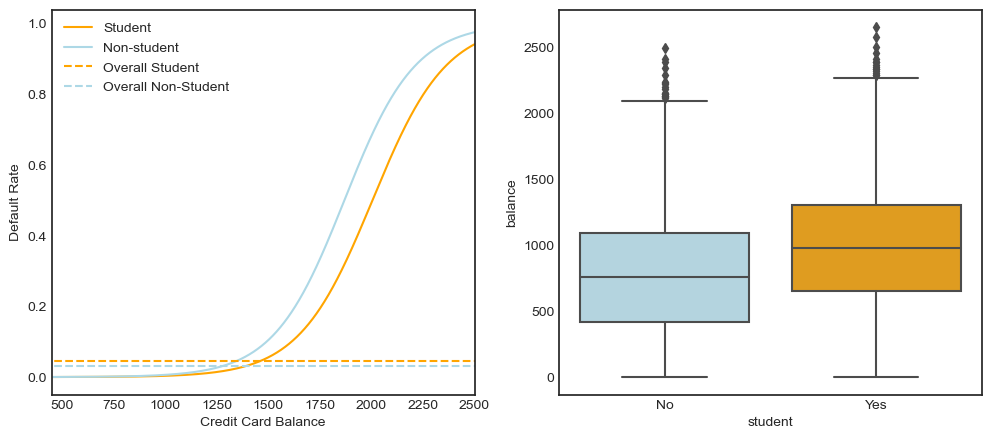

In [211]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
# -- change boxplot('student','balance', data=df) to (x='student', y='balance', data=df)
sns.boxplot(x='student', y='balance', data=df, orient='v', ax=ax2,  palette=c_palette);

## 4.4 Linear Discriminant Analysis
### Table 4.4

In [212]:
# -- change df[['balance', 'income', 'student2']].as_matrix() to df[['balance', 'income', 'student2']].values
X = df[['balance', 'income', 'student2']].values
# -- change df.default2.as_matrix() to df[['balance', 'income', 'student2']].values
y = df.default2.values

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [213]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



### Table 4.5

In [214]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
False,9435,140
True,232,193


# Lab
## 4.6.3 Linear Discriminant Analysis

In [215]:
df = pd.read_csv(r"C:\Users\user\Desktop\smarket.csv", usecols=range(1,10), index_col=0, parse_dates=True)

In [216]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

In [217]:
lda.priors_

array([0.49198397, 0.50801603])

In [218]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [219]:
# These do not seem to correspond to the values from the R output in the book?
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [220]:
confusion_matrix(y_test, pred).T

array([[ 35,  35],
       [ 76, 106]], dtype=int64)

In [221]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.500     0.315     0.387       111
          Up      0.582     0.752     0.656       141

    accuracy                          0.560       252
   macro avg      0.541     0.534     0.522       252
weighted avg      0.546     0.560     0.538       252



In [222]:
pred_p = lda.predict_proba(X_test)

In [223]:
np.unique(pred_p[:,1]>0.5, return_counts=True)

(array([False,  True]), array([ 70, 182], dtype=int64))

In [224]:
np.unique(pred_p[:,1]>0.9, return_counts=True)

(array([False]), array([252], dtype=int64))

## 4.6.4 Quadratic Discriminant Analysis

In [225]:
qda = QuadraticDiscriminantAnalysis()
pred = qda.fit(X_train, y_train).predict(X_test)

In [226]:
qda.priors_

array([0.49198397, 0.50801603])

In [227]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [228]:
confusion_matrix(y_test, pred).T

array([[ 30,  20],
       [ 81, 121]], dtype=int64)

In [229]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.600     0.270     0.373       111
          Up      0.599     0.858     0.706       141

    accuracy                          0.599       252
   macro avg      0.600     0.564     0.539       252
weighted avg      0.599     0.599     0.559       252



## 4.6.5 K-Nearest Neighbors

In [230]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[43 58]
 [68 83]]
              precision    recall  f1-score   support

        Down      0.426     0.387     0.406       111
          Up      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252



In [231]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[48 55]
 [63 86]]
              precision    recall  f1-score   support

        Down      0.466     0.432     0.449       111
          Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252



## 4.6.6 An Application to Caravan Insurance Data
### K-Nearest Neighbors

In [232]:
# In R, I exported the dataset from package 'ISLR' to a csv file
df = pd.read_csv(r"C:\Users\user\Desktop\caravan.csv")
y = df.Purchase
X = df.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

X_train = X_scaled[1000:,:]
y_train = y[1000:]
X_test = X_scaled[:1000,:]
y_test = y[:1000]

# -- change def KNN(n_neighbors = 1, weights = 'uniform') to KNN(n_neighbors = 1)
# -- change clf = neighbors.KNeighborsClassifier(n_neighbors) to clf = neighbors.KNeighborsClassifier(n_neighbors, weights = 'uniform')
def KNN(n_neighbors = 1):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights = 'uniform')
    clf.fit(X_train, y_train) 
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    return (pred, score, clf.classes_)

def plot_confusion_matrix(cm, classes, n_neighbors, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix: KNN-{}'.format(n_neighbors))
    plt.colorbar()
    plt.xticks(np.arange(2), classes)
    plt.yticks(np.arange(2), classes)
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

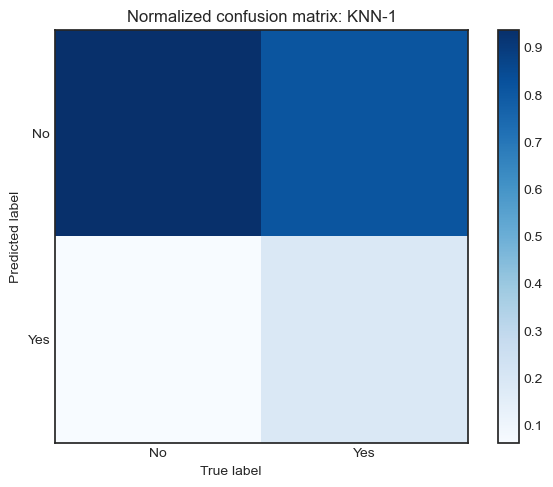

True        No  Yes
Predicted          
No         882   48
Yes         59   11
     Precision
No    0.948387
Yes   0.157143


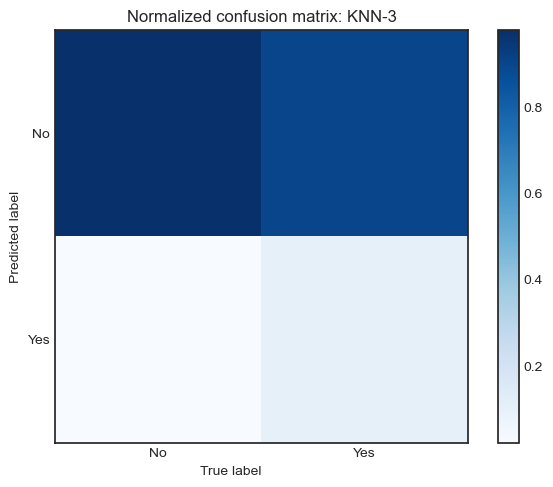

True        No  Yes
Predicted          
No         921   53
Yes         20    6
     Precision
No    0.945585
Yes   0.230769


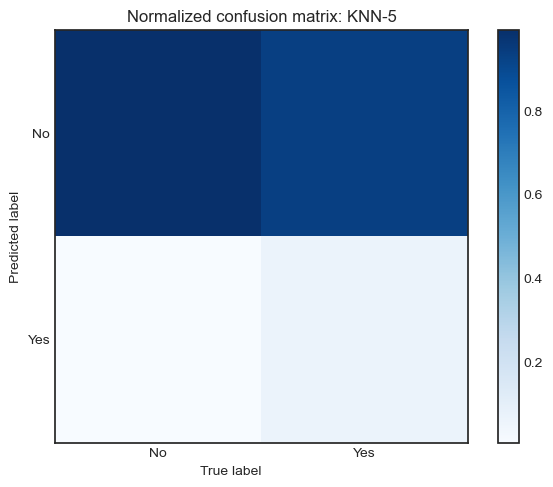

True        No  Yes
Predicted          
No         934   55
Yes          7    4
     Precision
No    0.944388
Yes   0.363636


In [233]:
for i in [1,3,5]:
    pred, score, classes = KNN(n_neighbors = i)
    cm = confusion_matrix(y_test, pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized.T, classes, n_neighbors=i)
    cm_df = pd.DataFrame(cm.T, index=classes, columns=classes)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)    
    print(pd.DataFrame(precision_score(y_test, pred, average=None),
                       index=classes, columns=['Precision']))     

### Logistic Regression

In [234]:
regr = skl_lm.LogisticRegression()
regr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [235]:
pred = regr.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))

True        No  Yes
Predicted          
No         935   59
Yes          6    0
              precision    recall  f1-score   support

          No       0.94      0.99      0.97       941
         Yes       0.00      0.00      0.00        59

    accuracy                           0.94      1000
   macro avg       0.47      0.50      0.48      1000
weighted avg       0.89      0.94      0.91      1000



In [236]:
pred_p = regr.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y_test, cm_df.Pred))

Pred   No  Yes
True          
No    918   23
Yes    48   11
              precision    recall  f1-score   support

          No       0.95      0.98      0.96       941
         Yes       0.32      0.19      0.24        59

    accuracy                           0.93      1000
   macro avg       0.64      0.58      0.60      1000
weighted avg       0.91      0.93      0.92      1000

